## Q1. Median Maintenance using a Heap


### Part 1

Implement a "dominant heap" class `BinaryHeap`, which can handle both the min heap and the max heap cases, by having the constructor explicitly pass the "comparison" operator in. Replace min and del_min by dominant and del_dominant methods. Change the classmethod to also take in the operator.

In [1]:
import operator as op

class BinaryHeap:
    """
    Description
    -----------
    Class that implements a Binary Heap
    with a user specified dominance operator
    
    Parameters
    ----------
    self: BinaryHeap instance
    comparison: 
        operator for determining dominance.
    """
    def __init__(self, comparison):
        
        # set defaults as instance attributes
        self.storage=[None]
        self.upto=0
        
        # handle comparison operator (<, >) and
        # dominance function (min/max)|
        try:
            self.comp_op = {'min': op.lt, 'max': op.gt}[comparison]
            self.dom_func = {'min': min, 'max': max}[comparison]
        except:
            raise KeyError('`comparison` must be `min` or `max`')
        
    @classmethod
    def heapify_slow(cls, it, comp):
        inst = cls(comparison=comp)
        for i in it:
            inst.insert(i)
        return inst
            
    def insert(self, value):
        self.storage.append(value)
        self.upto += 1
        self.sift_up(self.upto)

    def sift_up(self, i):
        parent = i // 2
        if parent > 0 and self.comp_op(self.storage[i], self.storage[parent]):
            self.storage[i], self.storage[parent] = self.storage[parent], self.storage[i]
            self.sift_up(parent)
     
    def _dom_child(self, i):
        if 2*i + 1 > self.upto:
            return 2*i
        else:
            l = (self.storage[2*i], self.storage[2*i+1])
            return 2*i + l.index(self.dom_func(l))
    
    def sift_down(self, i):
        #dotify(self.storage, "delimg"+str(i).zfill(2))
        if 2*i <= self.upto:
            child = self._dom_child(i)
            if self.comp_op(self.storage[child], self.storage[i]):
                self.storage[child], self.storage[i] = self.storage[i], self.storage[child]
                self.sift_down(child)
        
    def dominant(self):
        return self.storage[1]
    
    def del_dominant(self):
        domval = self.storage[1]
        self.storage[1], self.storage[self.upto] = self.storage[self.upto], self.storage[1]
        self.storage.pop()
        self.upto -= 1
        self.sift_down(1)
        return domval

In [2]:
data = [1,8,5,9,23,2,45,6,7,99,-5]

In [3]:
#from operator import gt, lt
bh = BinaryHeap.heapify_slow(data, 'min')
print(bh.storage)
bh.dominant()

[None, -5, 1, 2, 7, 6, 5, 45, 9, 8, 99, 23]


-5

In [4]:
bh2 = BinaryHeap.heapify_slow(data, 'max')
print(bh2.storage)
bh2.dominant()

[None, 99, 45, 23, 7, 9, 2, 5, 1, 6, 8, -5]


99

### Part 2

Median maintenance is a very cool algorithm to find an online median.
We create two arrays to test our implementation, using np.median to test our answer...

In [5]:
import random
import numpy as np
l = [random.randint(1,1000) for _ in range(150)]
print(len(l), np.median(l))
l2 = l + [random.randint(1,1000)]
print(len(l2), np.median(l2))

150 536.5
151 540.0


You will implement def online_median(iterator) which is a generator yielding successive values of your online median.

The algorithm is as follows:

- 2 heaps, a max heap for the lower half of the data, and a min-heap for the upper half
- take first 2 values in our data, assign smaller to the max heap, larger value to min-heap
- insert subsequent values:
    - if new value dominates dominant of min heap, add it to max heap and vice versa
- if heaps off balance by 2 or more, fix this by taking dom. elem. from larger heap and inserting to smaller
- in order to return, check if min and max heaps balanced in size
    - if not, return dominant of larger heap
    - if yes, return average of dominants

#### Original description
We'll use 2 heaps, a max heap for the lower half of the data, and a min-heap for the upper half. We take the first 2 values in our data and assign the smaller value to the max heap, while the larger value goes to the min-heap. Then, as we "insert" subsequent values in one of the two heaps, the following holds: if we keep the number of elements in both heaps equal (for the even case) or at-most differing by one, the median is respectively the average of the two dominants or the dominant in the heap with one extra item.

What then is our strategy for this balanced insertion? Quite simple really: if a new value is not as dominant as the dominant value, add it to that heap. If it is more dominant, add it to the other. If two items in a row get added to the same heap, the heaps will be out of balance by more than one. In this case, take the dominant element from the larger heap and simply add it to the smaller one.

In [6]:
# your code here
def online_median(my_iterable):
    """
    Description
    -----------
    Calculates an online median of `my_iterable`
    using a heap-based approach
    
    Parameters
    ----------
    my_iterable: iterable
    
    Returns
    -------
    m: float
        median value of `my_iterable`
    """
    
    # set up heaps
    minheap = BinaryHeap('min')
    maxheap = BinaryHeap('max')
        
    # insert first two
    first_two = [next(my_iterable) for _ in range(2)]
    minheap.insert(max(first_two))
    maxheap.insert(min(first_two))
    
    # insert subsequent values
    for val in my_iterable: 
        
        # determine where to insert
        if val < minheap.dominant():
            maxheap.insert(val)
        elif val > maxheap.dominant():
            minheap.insert(val)
        
        # rebalance heaps as needed
        len_diff = len(minheap.storage) - len(maxheap.storage)
        if len_diff < -1:
            minheap.insert(maxheap.del_dominant())
        elif len_diff > 1:
            maxheap.insert(minheap.del_dominant())
        
        if len(maxheap.storage) != len(minheap.storage):
            m = max([minheap, maxheap], key=lambda x: len(x.storage)).dominant()
        else:
            m = (minheap.dominant() + maxheap.dominant())/2.0

        yield m

Do your answers match?


536.5


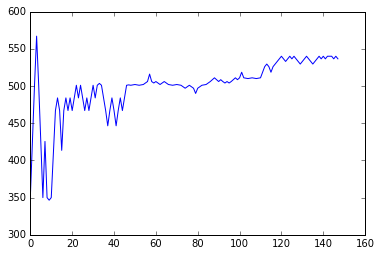

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
medians = list(online_median(iter(l)))
print(medians[-1])
plt.plot(medians)

In [8]:
list(online_median(iter(l2)))[-1]

540

Lastly, lets repeat the analysis we did last time on the randomly generated data.

In [9]:
from random import normalvariate, random
from itertools import count
def make_data(m, stop=None):
    for _ in count():
        if stop and _ > stop:
            break
        yield 1.0e09 + normalvariate(0, m*random() )

In [10]:
g = online_median(make_data(5, 100))
print(type(g))
out = list(g)
out[-10:]

<class 'generator'>


[1000000000.1230078,
 1000000000.1367793,
 1000000000.1514268,
 1000000000.1367793,
 1000000000.1230078,
 1000000000.1092361,
 1000000000.0718001,
 1000000000.0343641,
 1000000000.0718001,
 1000000000.1092361]

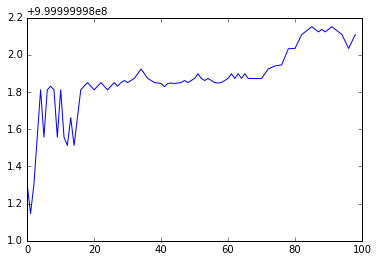

In [11]:
plt.plot(out)

## Q2

### Simulating a flight check-in counter

It is your job to simulate a flight-checkin counter. There are m agents handling n passengers. The passengers arrive in line with in-between time given by an exponential distribution for `INTER_ARRIVAL_TIME`. Each passenger, once he or she gets to a counter, is processed in a time drawn from an exponential distribution with `PROCESSING_TIME`. 

Clearly, in the usual case of 3-4 agents and 200+ customers on a flight, the customer waits much longer. We have been hired by the airlines customer-relations group to see how many extra agents must we hire to reduce waiting times by how much.

We start by representing each customer by a co-routine, which starts with the `inline` event. The state changes to the `atcounter` event, and then `ptime` seconds later, to the `leaves` event. Notice how this customer "process" is stopped at the yield, until the customer can be handled.

In [12]:
import collections, random
Event = collections.namedtuple('Event', 'time cid action agent')
def customer_process(idee, start, ptime):
    t, agent = yield Event(start, idee, "inline", None)
    t, agent = yield Event(t, idee, "atcounter", agent)
    yield Event(t+ptime, idee, "leaves", agent)

The following function simply implements the draw from the exponential distribution for a given customer:

In [13]:
def duration(arr_time, service_time):
    return random.expovariate(1./arr_time), random.expovariate(1./service_time)

Here is out main simulation class. you will be filling in parts of this class.

The constructor sets up the simulation. Three queues are created, one for agents that become free, one priority queue for events so that they can be processed in the order recieved, and a backlog for queue for those customers waiting in line because no agent was available.

We set up all the customers in the constructor, with two dictionaries, one to hold the co-routines, and one to hold time metadata which we shall use to figure the average waiting time.

The `run` method is where all the action happens and is the one you will edit.

In [14]:
import queue
import logging
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler())
class Simulator:
    """
    Description
    -----------
    Simulates the flight check-in process
    
    Parameters
    ----------
    n_agents: int
        no. of agents / check-in counters
    n_customers: int
        no. of customers
    INTER_ARRIVAL_TIME: float
        average inter-arrival time (1/lambda for expo distribution)
    PROCESSING_TIME: float
        average processing time (1/lambda for expo distribution)
    DEBUG: bool
        flag for controlling logging level
        
        
    Returns
    -------
    :)
    """
    def __init__(self, n_agents, n_customers, INTER_ARRIVAL_TIME =1., PROCESSING_TIME=3., DEBUG=False ): 
        
        # Instantiate Queues
        self.free_agents = queue.Queue()
        self.backlog = queue.Queue()
        self.events=queue.PriorityQueue()
        
        # Save other arguments as instance attributes
        self.n_customers = n_customers
        self.n_agents = n_agents
        self.intertime = INTER_ARRIVAL_TIME
        self.proctime = PROCESSING_TIME
        
        # Create dictionaries to hold the customer process
        self.customers={}
        self.customer_meta={}
        self.logger = logging.getLogger("sim")
        
        # Control the debugging level
        if DEBUG:
            self.logger.setLevel(logging.DEBUG)
        else:
            self.logger.setLevel(logging.WARNING)
        
        # On the free_agents queue, we store all the agents, 
        # as well as the times they became free.
            
        # Obviously, they are all free at t = 0
        for i in range(n_agents):
            self.free_agents.put((i, 0))
        
        # We now also track when each customer initially came in.
        time_when_came = 0.
        for j in range(n_customers):
            
            # Use `duration` to sample an inter-arrival and processing time
            interarrtime, proctime = duration(self.intertime, self.proctime)
            time_when_came += interarrtime
            
            # Represent the arrival metadata as a tuple
            intuple = (j, time_when_came, proctime)
            
            # Feed the arrival into the `customer_process` generator
            c = customer_process(*intuple)
            
            # Log the arrival time of the customer
            self.logger.debug("Customer {}, arrived {}, will take {} at counter".format(*intuple))
            
            # Add each customer's process to dictionaries
            self.customers[j] = c
            self.customer_meta[j] = {'cid':j, 'start':time_when_came, 'finish':None}
        
        self.logger.debug("========ending init==============\n\n")
        
        # Update max arrival time 
        self.max_time_when_came = time_when_came  

    def run(self, end_time):
        
        # We prime each customer co-routine at the start
        # and put that event in the events priority queue
        
        # Since an event is a tuple, the ordering will be by start time
        for cid, proc in sorted(self.customers.items()):
            first_event = next(proc) # prime
            self.events.put(first_event) # customer in line

        # Start simulation at time 0
        sim_time = 0
        while sim_time < end_time:
            

            # STEP 1: FETCH CURRENT EVENT 

            # CASE 1: Degenerate case: if no events and no backlog, do nothing
            if self.events.empty() and self.backlog.empty(): 
                self.logger.debug('*** end of events and backlog***') 
                break
            
            # CASE 2: we have agents available and a backlog of customers
            # We take customer from backlog queue. This is equivalent 
            # to taking customers from line where they wait.
            if not self.backlog.empty() and not self.free_agents.empty():
                
                # take customer from backlog
                current_event = self.backlog.get()
                
                # The sim time from this branch will be false as we
                # get the old time when the person in line showed up
            
            # CASE 3: Either backlog is empty or there are no free agents
            else: 

                # get current event from `self.events` in all other cases
                # This ensures that leave events are processed
                # thus freeing up agents

                current_event = self.events.get()


            # STEP 2: log what actually happens in `current_event` and update

            # first bind variables to the current event
            sim_time, cid, action, agent = current_event
            
            # Get the current customer process
            cproc = self.customers[cid]
                
            if action=='leaves':
                self.logger.debug(">>>Customer {} leaves, agent {} free at {}".format(cid, agent, sim_time))
                
                # An agent gets free. Put the time they got free
                # on the queue, and also update the metadata
                
                self.free_agents.put((agent, sim_time))
                self.customer_meta[cid]['finish']=sim_time
                continue # no need to `cproc.send()`

            elif action=='atcounter':
                self.logger.debug("Customer {} atcounter Agent {} at {}".format(cid, agent, sim_time))
                next_time = sim_time
                # NB: processing time is already stored in the coroutine under `ptime`

            elif action=='inline':#the agent is None to start
                self.logger.debug('----------------------------------------------')
                self.logger.debug("Customer {}, arrived in line @ {}.".format(cid, sim_time))

                if self.free_agents.empty():
                    self.logger.debug("NO agents available, putting {} inline on backlog at {}".format(cid, sim_time))
                    
                    # put customer in backlog
                    self.backlog.put(current_event)

                    # loop again, skipping `cproc.send()`
                    continue

                else:
                    self.logger.debug("{} agents available to serve.".format(self.free_agents.qsize()))
                    "YOUR CODE HERE"#handle both situations
                    #of getting from backlog or regular. The time in
                    #next_time which you will send in message to co-routine
                    #below are different

                    agent, time = self.free_agents.get()
                    next_time = max(sim_time, time)

                    self.logger.debug("Customer {} inline to be served by Agent {} at {}".format(cid, agent, next_time))
            
            #drive the co-routine by sending in time and agent, and getting
            #next event out. The event is put into the priority queue.
            try:
                next_event = cproc.send((next_time, agent)) 
            except StopIteration:
                del self.customers[cid] 
            else:
                self.events.put(next_event)
                
    def compute_ptimes(self):
        ptimes=[]
        for j in range(self.n_customers):
            #print(j,self.customer_meta[j] )
            if self.customer_meta[j]['finish']!=None:
                ptimes.append(self.customer_meta[j]['finish'] - self.customer_meta[j]['start'])
        return ptimes

In [15]:
def sim_main(num_agents, num_customers, extratime=20., seed=None, debug=False):
    if seed is not None:
        random.seed(seed)
    sim = Simulator(num_agents, num_customers, DEBUG=debug)
    sim.run(sim.max_time_when_came+extratime)
    return sim

Start small to test this out.

In [16]:
sim=sim_main(2,6, debug=True)

Customer 0, arrived 2.510166981376265, will take 0.40056037709946907 at counter
Customer 1, arrived 3.1107293623128496, will take 14.113155317058885 at counter
Customer 2, arrived 3.5886281541715825, will take 0.48411317406711635 at counter
Customer 3, arrived 3.755271910773751, will take 0.49877472999207195 at counter
Customer 4, arrived 5.407707445930628, will take 0.9048674773212159 at counter
Customer 5, arrived 5.474045708529924, will take 4.70495721768666 at counter
========ending init==============


----------------------------------------------
Customer 0, arrived in line @ 2.510166981376265.
2 agents available to serve.
Customer 0 inline to be served by Agent 0 at 2.510166981376265
Customer 0 atcounter Agent 0 at 2.510166981376265
>>>Customer 0 leaves, agent 0 free at 2.910727358475734
----------------------------------------------
Customer 1, arrived in line @ 3.1107293623128496.
2 agents available to serve.
Customer 1 inline to be served by Agent 1 at 3.1107293623128496
Cus

Now lets try it with some larger numbers.

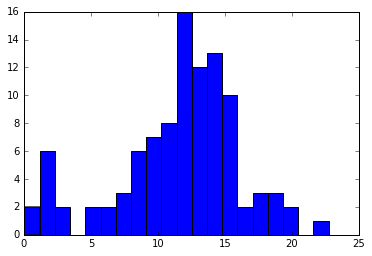

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
sim=sim_main(3,100)
plt.hist(sim.compute_ptimes(), bins=20);

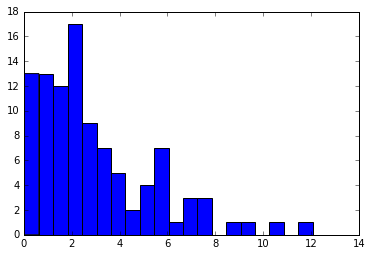

In [18]:
sim2=sim_main(4,100)
plt.hist(sim2.compute_ptimes(), bins=20);

extra time needed below as with 400 passengers a long time is taken to process.

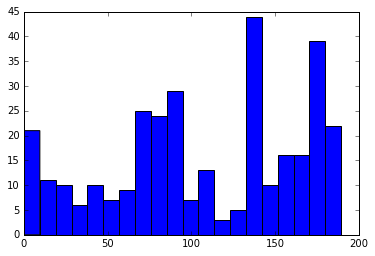

In [19]:
sim2=sim_main(2,400, extratime=100)
plt.hist(sim2.compute_ptimes(), bins=20);

For a proper statistical analysis, you would want to draw this multiple times and look at the distribution of the averages as well. But you should know what this distribution is :-).